Загрузка данных из Excel...
Загружено 300 образцов
Распределение классов: [100 100 100]

Нормализация данных...

Разделение данных на обучающую и тестовую выборки...
Размер обучающей выборки: (240, 299)
Размер тестовой выборки: (60, 299)
Для сохранения 99.0% дисперсии требуется 21 компонент из 299
PCA()


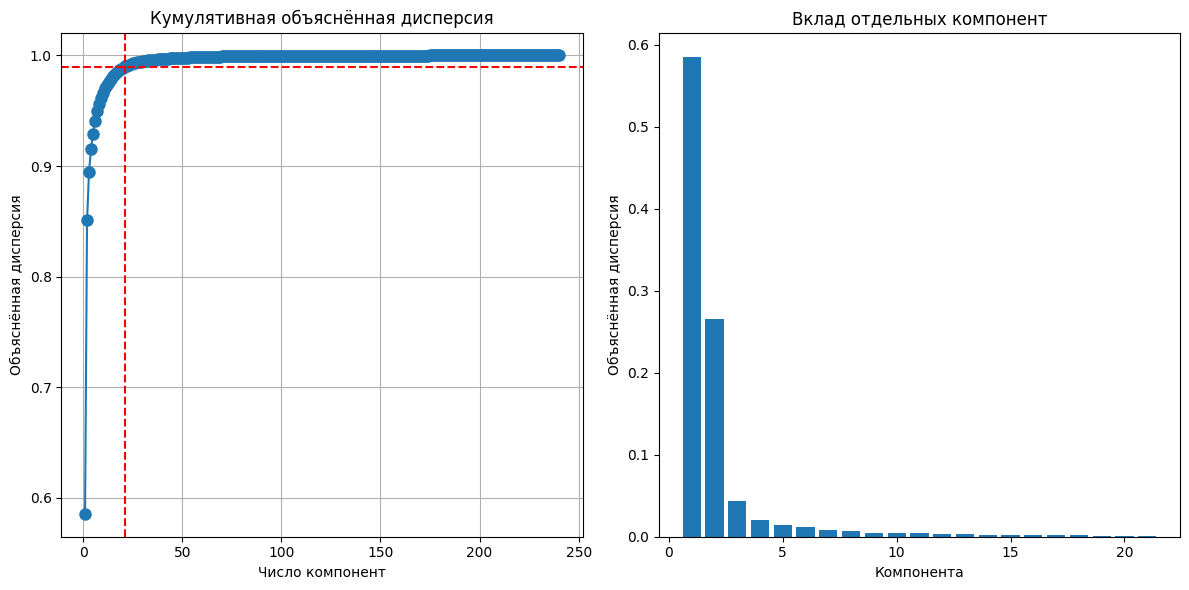

Эпоха 0: Total=14.555, CE=1.536, Smooth=0.093, Group=12.926
Эпоха 300: Total=1.117, CE=0.983, Smooth=0.018, Group=0.116
Эпоха 600: Total=1.006, CE=0.975, Smooth=0.012, Group=0.019
Эпоха 900: Total=1.001, CE=0.972, Smooth=0.012, Group=0.017
Эпоха 1200: Total=1.001, CE=0.972, Smooth=0.012, Group=0.017
Эпоха 1500: Total=1.001, CE=0.972, Smooth=0.012, Group=0.017
Эпоха 1800: Total=1.001, CE=0.972, Smooth=0.012, Group=0.017
Эпоха 2100: Total=1.001, CE=0.972, Smooth=0.012, Group=0.016
Эпоха 2400: Total=1.001, CE=0.972, Smooth=0.012, Group=0.017
Эпоха 2700: Total=1.001, CE=0.972, Smooth=0.012, Group=0.017


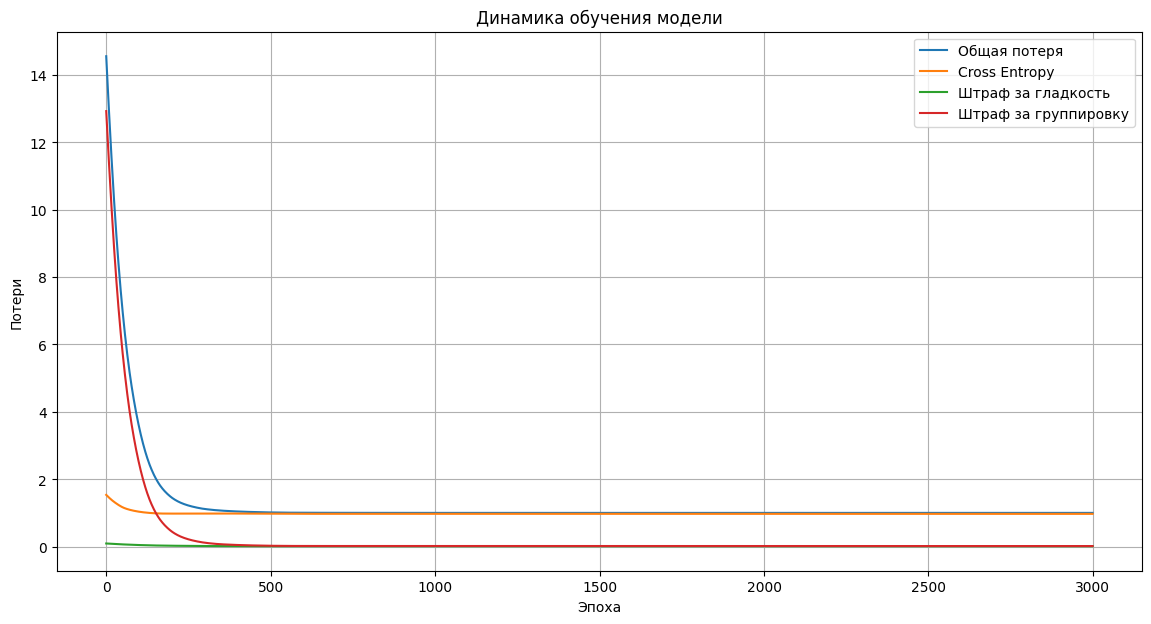

Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        20
          12       0.45      0.25      0.32        20
          24       0.57      0.65      0.60        20

    accuracy                           0.50        60
   macro avg       0.49      0.50      0.48        60
weighted avg       0.49      0.50      0.48        60


Confusion Matrix:
[[12  4  4]
 [ 9  5  6]
 [ 5  2 13]]


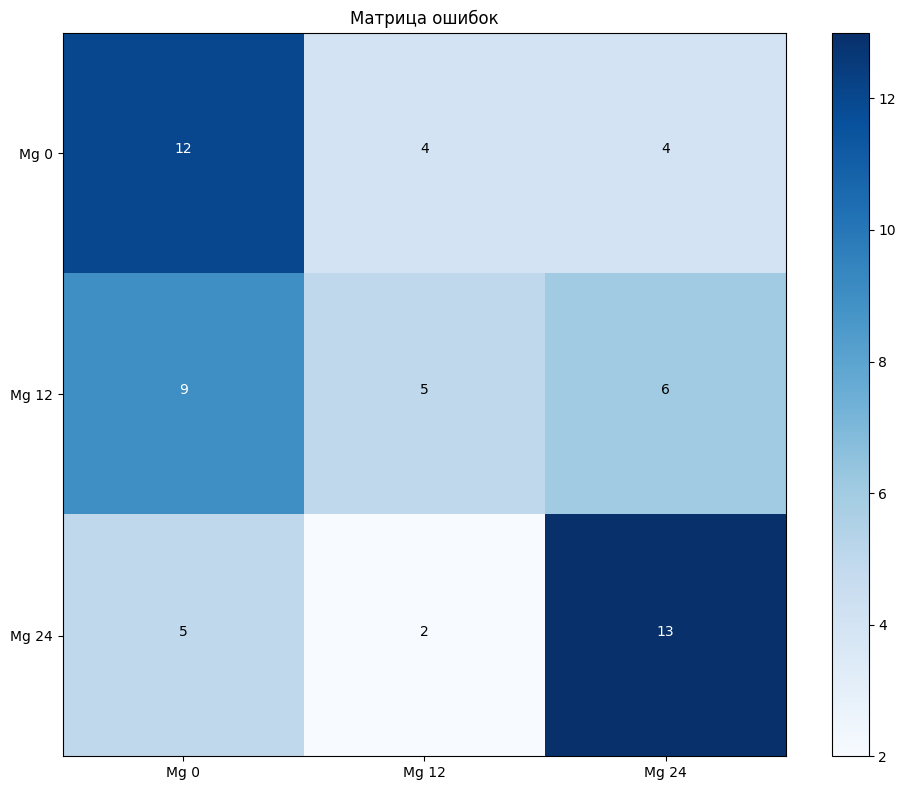

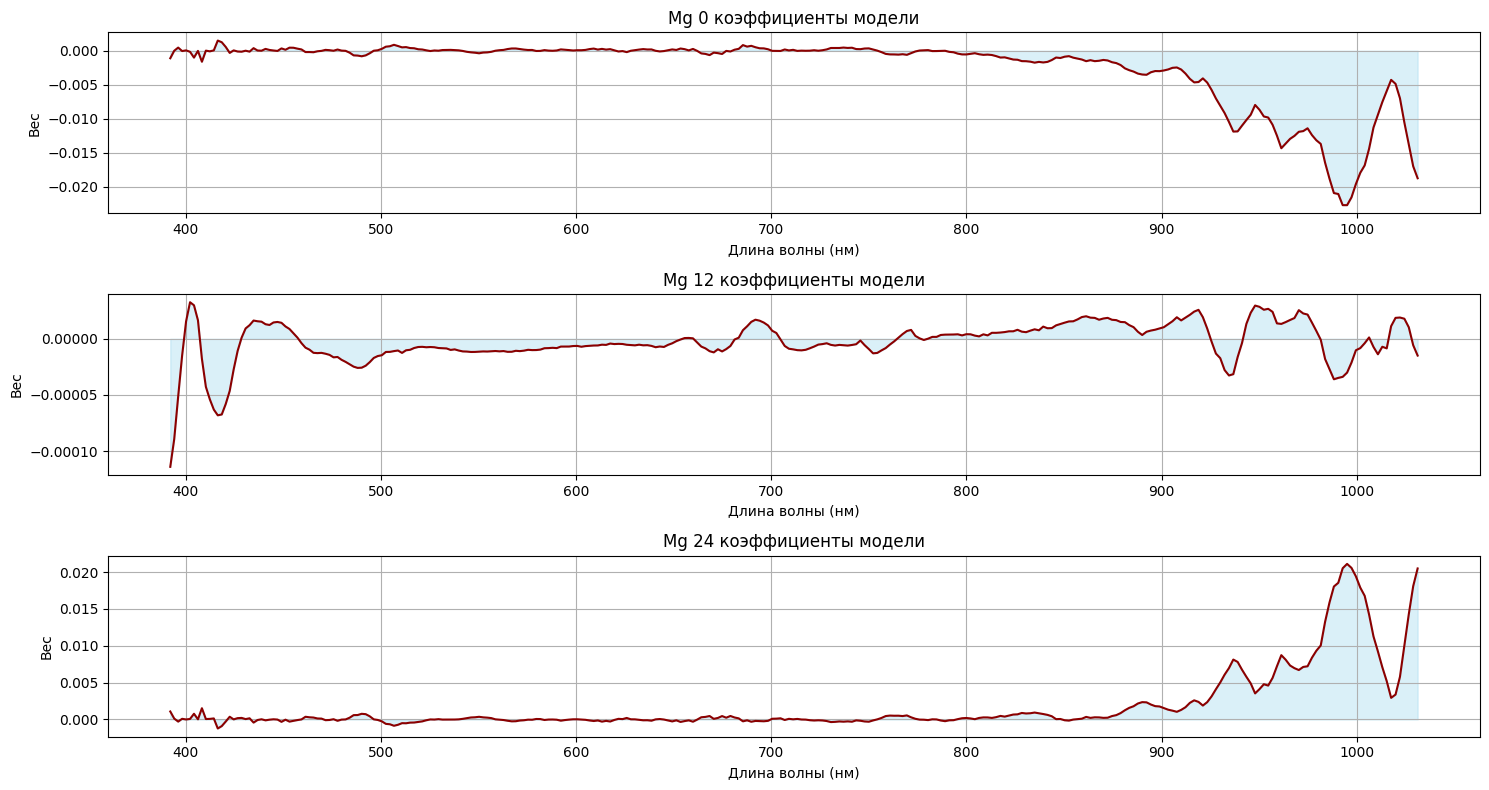

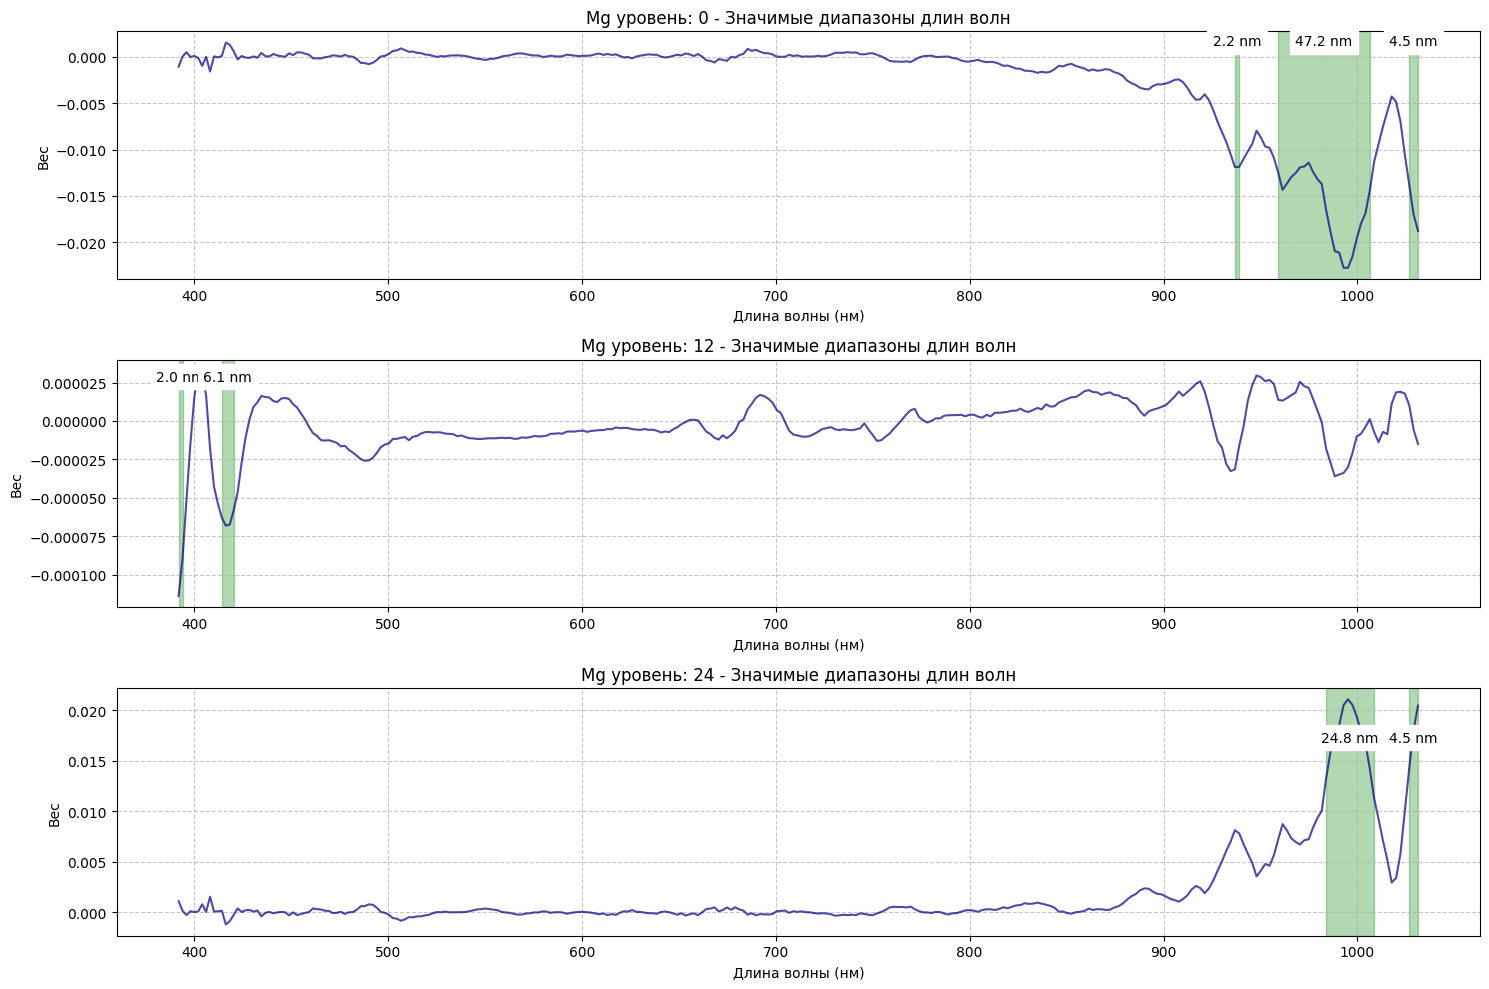


Значимые диапазоны длин волн по классам:
Mg 0: 936.8-939.0 нм (2.2 нм), 959.1-1006.4 нм (47.2 нм), 1026.7-1031.2 нм (4.5 нм)
Mg 12: 392.1-394.1 нм (2.0 нм), 414.4-420.5 нм (6.1 нм)
Mg 24: 983.8-1008.6 нм (24.8 нм), 1026.7-1031.2 нм (4.5 нм)

Модель успешно обучена! Данные успешно преобразованы с помощью PCA.


In [12]:
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
                           confusion_matrix, classification_report, cohen_kappa_score)
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import label_binarize
from scipy.stats import sem
from sklearn.decomposition import PCA
import torch

def extended_model_evaluation(model, X_test_pca, y_test, mg_levels, pca_model=None, X_test_original=None):
    """
    Проводит расширенную оценку модели с расчетом различных метрик.
    
    Args:
        model: Обученная модель PyTorch
        X_test_pca: Тестовые данные после PCA-преобразования
        y_test: Истинные метки классов
        mg_levels: Уровни магния [0, 12, 24]
        pca_model: Модель PCA (опционально)
        X_test_original: Тестовые данные до PCA-преобразования (опционально)
    """
    model.eval()
    with torch.no_grad():
        # Прогноз вероятностей и классов
        X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
        outputs = model(X_test_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
        _, predicted_indices = torch.max(outputs, 1)
        predicted_indices = predicted_indices.numpy()
        
        # Преобразуем индексы в значения магния
        y_pred_mg = np.array([mg_levels[i] for i in predicted_indices])
        
        # Преобразуем истинные метки в индексы классов для метрик
        mg_to_idx = {mg: idx for idx, mg in enumerate(mg_levels)}
        y_test_idx = np.array([mg_to_idx[y] for y in y_test])
        
        # 1. Базовые метрики
        accuracy = accuracy_score(y_test, y_pred_mg)
        precision = precision_score(y_test_idx, predicted_indices, average='weighted')
        recall = recall_score(y_test_idx, predicted_indices, average='weighted')
        f1 = f1_score(y_test_idx, predicted_indices, average='weighted')
        kappa = cohen_kappa_score(y_test_idx, predicted_indices)
        
        print("\n=== ОСНОВНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ ===")
        print(f"Точность (Accuracy): {accuracy:.4f}")
        print(f"Точность (Precision): {precision:.4f}")
        print(f"Полнота (Recall): {recall:.4f}")
        print(f"F1-мера: {f1:.4f}")
        print(f"Коэффициент Каппа: {kappa:.4f}")
        
        # 2. Подробный отчет по классификации
        print("\n=== ОТЧЕТ ПО КЛАССИФИКАЦИИ ===")
        print(classification_report(y_test, y_pred_mg))
        
        # 3. Матрица ошибок
        print("\n=== МАТРИЦА ОШИБОК ===")
        cm = confusion_matrix(y_test_idx, predicted_indices)
        print(cm)
        
        # Визуализация матрицы ошибок
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[f'Mg {level}' for level in mg_levels],
                   yticklabels=[f'Mg {level}' for level in mg_levels])
        plt.title('Матрица ошибок')
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.tight_layout()
        plt.savefig('confusion_matrix_detailed.png')
        plt.show()
        
        # 4. ROC-кривые и AUC
        # Бинаризуем метки для ROC-AUC
        y_test_bin = label_binarize(y_test_idx, classes=np.arange(len(mg_levels)))
        
        plt.figure(figsize=(10, 8))
        for i, mg in enumerate(mg_levels):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
            auc = roc_auc_score(y_test_bin[:, i], probabilities[:, i])
            plt.plot(fpr, tpr, lw=2, label=f'Mg {mg} (AUC = {auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривые для каждого класса')
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('roc_curves.png')
        plt.show()
        
        # 5. Кривые точность-полнота
        plt.figure(figsize=(10, 8))
        for i, mg in enumerate(mg_levels):
            precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin[:, i], probabilities[:, i])
            ap = average_precision_score(y_test_bin[:, i], probabilities[:, i])
            plt.plot(recall_curve, precision_curve, lw=2, 
                    label=f'Mg {mg} (AP = {ap:.3f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Полнота (Recall)')
        plt.ylabel('Точность (Precision)')
        plt.title('Кривые точность-полнота для каждого класса')
        plt.legend(loc="lower left")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('precision_recall_curves.png')
        plt.show()
        
        # 6. Анализ ошибок
        if X_test_original is not None and pca_model is not None:
            # Находим неправильно классифицированные примеры
            misclassified = (y_pred_mg != y_test)
            
            if np.sum(misclassified) > 0:
                print(f"\n=== АНАЛИЗ ОШИБОК ({np.sum(misclassified)} неправильно классифицированных примеров) ===")
                
                # Восстанавливаем исходные признаки для ошибочных примеров
                X_test_pca_misclassified = X_test_pca[misclassified]
                X_original_misclassified = X_test_original[misclassified]
                reconstructed_misclassified = pca_model.inverse_transform(X_test_pca_misclassified)
                
                # Рассчитываем ошибку реконструкции
                reconstruction_error = np.mean((X_original_misclassified - reconstructed_misclassified)**2, axis=1)
                print(f"Средняя ошибка реконструкции для неправильных примеров: {np.mean(reconstruction_error):.6f}")
                
                # Визуализируем примеры с наибольшей ошибкой реконструкции
                plt.figure(figsize=(12, 8))
                top_error_idx = np.argsort(reconstruction_error)[-3:]  # 3 примера с наибольшей ошибкой
                for i, idx in enumerate(top_error_idx):
                    plt.subplot(3, 1, i+1)
                    plt.plot(range(len(X_original_misclassified[idx])), 
                             X_original_misclassified[idx], 'b-', label='Исходный спектр')
                    plt.plot(range(len(reconstructed_misclassified[idx])), 
                             reconstructed_misclassified[idx], 'r--', label='Реконструированный')
                    plt.title(f'Ошибочно классифицированный пример: реальный Mg {y_test[misclassified][idx]}, '
                             f'предсказано Mg {y_pred_mg[misclassified][idx]}')
                    plt.legend()
                plt.tight_layout()
                plt.savefig('misclassified_examples.png')
                plt.show()
        
        # Возвращаем основные метрики и предсказания для дальнейшего анализа
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'kappa': kappa,
            'predictions': y_pred_mg,
            'probabilities': probabilities
        }


# Функция для применения PCA
def apply_pca_reduction(X, variance_threshold=0.99):
    """
    Применяет PCA и возвращает преобразованные данные и модель PCA.
    """
    # Инициализируем PCA с полным числом компонент
    pca = PCA()
    pca.fit(X)
    
    # Определяем оптимальное число компонент
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    print(f"Для сохранения {variance_threshold*100:.1f}% дисперсии требуется {n_components} компонент из {X.shape[1]}")
    
    # Применяем PCA с оптимальным числом компонент
    pca_optimal = PCA(n_components=n_components)
    X_pca = pca_optimal.fit_transform(X)
    print(pca)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), 
             cumulative_variance, 'o-', markersize=8)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.axvline(x=n_components, color='r', linestyle='--')
    plt.title(f'Кумулятивная объяснённая дисперсия')
    plt.xlabel('Число компонент')
    plt.ylabel('Объяснённая дисперсия')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_[:n_components])
    plt.title('Вклад отдельных компонент')
    plt.xlabel('Компонента')
    plt.ylabel('Объяснённая дисперсия')
    plt.tight_layout()
    plt.savefig('pca_analysis.png')
    plt.show()
    
    return X_pca, pca_optimal

# Класс логистической регрессии с пользовательскими регуляризаторами
class EnhancedSpectralModelWithPCA(nn.Module):
    def __init__(self, input_size, pca_model, distance_matrix, lambda_smooth=0.1, lambda_group=0.1):
        super().__init__()
        self.pca_model = pca_model
        self.linear = nn.Linear(input_size, 3)  # 3 класса (Mg 0, 12, 24)
        
        # Восстановление весов в исходном пространстве для применения регуляризации
        self.original_space_components = torch.tensor(pca_model.components_, dtype=torch.float32)
        
        # Для регуляризации
        self.distance_matrix = torch.tensor(distance_matrix, dtype=torch.float32)
        self.lambda_smooth = lambda_smooth
        self.lambda_group = lambda_group
        
        # Матрица смежности для сглаживания (1 для соседей)
        original_size = distance_matrix.shape[0]
        self.neighbor_mask = torch.zeros(original_size, original_size, dtype=torch.float32)
        for i in range(1, original_size-1):
            self.neighbor_mask[i, i-1] = 1
            self.neighbor_mask[i, i+1] = 1
        # Для крайних элементов
        self.neighbor_mask[0, 1] = 1
        self.neighbor_mask[original_size-1, original_size-2] = 1
    
    def get_original_space_weights(self):
        """Преобразует веса из пространства PCA в исходное пространство признаков"""
        return torch.mm(self.linear.weight, self.original_space_components)
    
    def smooth_penalty(self):
        """Штраф за резкие изменения между соседними спектрами"""
        weights = self.get_original_space_weights()
        diff = torch.mm(weights, self.neighbor_mask) - weights
        return self.lambda_smooth * torch.norm(diff, p=2)
    
    def group_penalty(self):
        """Штраф за разброс значимых диапазонов"""
        weights = self.get_original_space_weights().abs()
        return self.lambda_group * torch.sum(weights @ self.distance_matrix @ weights.T)

    def forward(self, x):
        return self.linear(x)

# Функция обучения модели
# Исправленная функция обучения модели
def train_enhanced_model_with_pca(X_train_pca, y_train, pca_model, distance_matrix, 
                                  lambda_smooth=0.000001, lambda_group=0.000001, 
                                  num_epochs=3000):
    """
    Обучает модель логистической регрессии с пользовательскими регуляризаторами
    на данных, преобразованных с помощью PCA.
    """
    # Преобразуем данные в тензоры
    X_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
    
    # Исправленный код для создания тензора меток
    # Создаем словарь для маппинга уровней магния на индексы классов
    mg_to_idx = {0: 0, 12: 1, 24: 2}
    y_indices = np.array([mg_to_idx[val] for val in y_train])
    y_tensor = torch.tensor(y_indices, dtype=torch.long)
    
    # Инициализируем модель
    model = EnhancedSpectralModelWithPCA(
        input_size=X_train_pca.shape[1],
        pca_model=pca_model,
        distance_matrix=distance_matrix,
        lambda_smooth=lambda_smooth,
        lambda_group=lambda_group
    )
    
    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # История потерь
    loss_history = {'total': [], 'ce': [], 'smooth': [], 'group': []}
    
    # Обучение
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_tensor)
        ce_loss = criterion(outputs, y_tensor)
        smooth_loss = model.smooth_penalty()
        group_loss = model.group_penalty()
        total_loss = ce_loss + smooth_loss + group_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Логирование
        loss_history['total'].append(total_loss.item())
        loss_history['ce'].append(ce_loss.item())
        loss_history['smooth'].append(smooth_loss.item())
        loss_history['group'].append(group_loss.item())
        
        if epoch % 300 == 0:
            print(f'Эпоха {epoch}: Total={total_loss.item():.3f}, CE={ce_loss.item():.3f}, '
                  f'Smooth={smooth_loss.item():.3f}, Group={group_loss.item():.3f}')
    
    # Визуализация потерь
    plt.figure(figsize=(14, 7))
    plt.plot(loss_history['total'], label='Общая потеря')
    plt.plot(loss_history['ce'], label='Cross Entropy')
    plt.plot(loss_history['smooth'], label='Штраф за гладкость')
    plt.plot(loss_history['group'], label='Штраф за группировку')
    plt.title('Динамика обучения модели')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves_pca.png')
    plt.show()
    
    return model, loss_history
# Функция для оценки модели
def evaluate_model_on_pca(model, X_test_pca, y_test, mg_levels):
    """
    Оценивает модель на тестовых данных, преобразованных с помощью PCA.
    """
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy()
        
        # Преобразуем индексы в значения магния
        y_pred_mg = np.array([mg_levels[i] for i in predicted])
        
        # Считаем точность
        accuracy = np.mean(y_pred_mg == y_test)
        
        # Вывод метрик
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_mg))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred_mg))
        
        # Визуализация матрицы ошибок
        cm = confusion_matrix(y_test, y_pred_mg)
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Матрица ошибок')
        plt.colorbar()
        tick_marks = np.arange(len(mg_levels))
        plt.xticks(tick_marks, [f'Mg {level}' for level in mg_levels])
        plt.yticks(tick_marks, [f'Mg {level}' for level in mg_levels])
        
        # Подписи значений на матрице
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, str(cm[i, j]), 
                         horizontalalignment="center", 
                         color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.savefig('confusion_matrix_pca.png')
        plt.show()
        
        return accuracy, y_pred_mg

# Визуализация весов в исходном пространстве
def visualize_model_weights(model, wavelengths, mg_levels):
    """
    Визуализирует веса модели в исходном пространстве признаков.
    """
    original_weights = model.get_original_space_weights().detach().numpy()
    
    plt.figure(figsize=(15, 8))
    for i, mg in enumerate(mg_levels):
        plt.subplot(3, 1, i+1)
        plt.plot(wavelengths, original_weights[i], color='darkred')
        plt.fill_between(wavelengths, original_weights[i], alpha=0.3, color='skyblue')
        plt.title(f'Mg {mg} коэффициенты модели')
        plt.xlabel('Длина волны (нм)')
        plt.ylabel('Вес')
        plt.grid(True)
    plt.tight_layout()
    plt.savefig('model_weights_pca.png')
    plt.show()

# Функция для визуализации значимых диапазонов
def visualize_significant_ranges(model, wavelengths, mg_levels, threshold=0.5):
    """
    Визуализирует значимые диапазоны длин волн на основе весов модели.
    """
    weights = model.get_original_space_weights().detach().numpy()
    significant_ranges = identify_significant_ranges(weights, wavelengths, threshold)
    
    plt.figure(figsize=(15, 10))
    
    for i, mg in enumerate(mg_levels):
        plt.subplot(3, 1, i+1)
        
        # Построение весов
        plt.plot(wavelengths, weights[i], color='navy', alpha=0.7)
        
        # Выделение значимых диапазонов
        for range_start, range_end in significant_ranges[i]:
            plt.axvspan(range_start, range_end, alpha=0.3, color='green')
            mid_point = (range_start + range_end) / 2
            width = range_end - range_start
            plt.text(mid_point, 0.8 * np.max(weights[i]), f"{width:.1f} nm", 
                     horizontalalignment='center', backgroundcolor='white')
        
        plt.title(f'Mg уровень: {mg} - Значимые диапазоны длин волн')
        plt.xlabel('Длина волны (нм)')
        plt.ylabel('Вес')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('significant_ranges_pca.png')
    plt.show()

# Функция для выявления значимых диапазонов длин волн
def identify_significant_ranges(weights, wavelengths, threshold=0.5):
    significant_ranges = []
    
    for class_idx in range(weights.shape[0]):
        class_weights = weights[class_idx]
        # Нормализация весов
        normalized_weights = np.abs(class_weights) / np.max(np.abs(class_weights))
        # Нахождение значимых длин волн
        significant_idx = np.where(normalized_weights > threshold)[0]
        
        # Группировка в диапазоны
        ranges = []
        if len(significant_idx) > 0:
            start_idx = significant_idx[0]
            current_range = [wavelengths[start_idx], wavelengths[start_idx]]
            
            for i in range(1, len(significant_idx)):
                if significant_idx[i] == significant_idx[i-1] + 1:
                    # Продолжение текущего диапазона
                    current_range[1] = wavelengths[significant_idx[i]]
                else:
                    # Завершение текущего диапазона и начало нового
                    ranges.append(current_range)
                    current_range = [wavelengths[significant_idx[i]], wavelengths[significant_idx[i]]]
            
            # Добавление последнего диапазона
            ranges.append(current_range)
        
        significant_ranges.append(ranges)
    
    return significant_ranges

# Основной код для выполнения полного пайплайна
def run_pca_enhanced_regression_pipeline(X, y, wavelengths, mg_levels, 
                                         test_size=0.2, random_state=42,
                                         variance_threshold=0.99,
                                         lambda_smooth=0.000001, 
                                         lambda_group=0.000001,
                                         num_epochs=3000):
    """
    Выполняет полный пайплайн:
    1. Разделение данных
    2. Применение PCA
    3. Обучение модели с пользовательскими регуляризаторами
    4. Оценка модели
    5. Визуализация результатов
    """
    # 1. Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 2. Сортировка длин волн и создание матрицы расстояний
    sorted_idx = np.argsort(wavelengths)
    sorted_wavelengths = wavelengths[sorted_idx]
    distance_matrix = np.abs(sorted_wavelengths[:, None] - sorted_wavelengths[None, :])
    
    # 3. Применение PCA
    X_train_pca, pca_model = apply_pca_reduction(X_train, variance_threshold)
    X_test_pca = pca_model.transform(X_test)
    
    # 4. Обучение модели на PCA-данных
    model, loss_history = train_enhanced_model_with_pca(
        X_train_pca, y_train, pca_model, distance_matrix,
        lambda_smooth=lambda_smooth, lambda_group=lambda_group,
        num_epochs=num_epochs
    )
    
    # 5. Оценка модели
    test_accuracy, test_predictions = evaluate_model_on_pca(model, X_test_pca, y_test, mg_levels)
    
    # 6. Визуализация весов и значимых диапазонов
    visualize_model_weights(model, sorted_wavelengths, mg_levels)
    visualize_significant_ranges(model, sorted_wavelengths, mg_levels, threshold=0.5)
    
    # 7. Вывод значимых диапазонов
    weights = model.get_original_space_weights().detach().numpy()
    significant_ranges = identify_significant_ranges(weights, sorted_wavelengths, threshold=0.5)
    
    print("\nЗначимые диапазоны длин волн по классам:")
    for i, mg in enumerate(mg_levels):
        if significant_ranges[i]:
            range_str = ", ".join([f"{start:.1f}-{end:.1f} нм ({end-start:.1f} нм)" 
                                  for start, end in significant_ranges[i]])
            print(f"Mg {mg}: {range_str}")
        else:
            print(f"Mg {mg}: Нет значимых диапазонов с порогом 0.5")
    
    return model, pca_model, test_accuracy

# Запуск полного пайплайна (предполагается, что X_scaled, y, wavelengths, mg_levels уже определены)
# Замените следующий код на вызов функции с вашими данными:



def load_data_from_excel(file_path):
    # Списки для хранения данных
    all_spectra = []
    all_labels = []
    wavelengths = None
    
    # Уровни магния соответствующие листам
    mg_levels = [0, 12, 24]
    
    # Чтение каждого листа
    for sheet_idx, sheet_name in enumerate(['Mg0', 'Mg1', 'Mg2']):
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Получаем длины волн из первого столбца (начиная со 2-й строки)
        if wavelengths is None:
            wavelengths = df.iloc[1:, 0].values
        
        # Для каждого земельного участка (каждый столбец, начиная со 2-го)
        for col_idx in range(1, df.shape[1]):
            # Получаем спектральные данные для этого участка
            spectrum = df.iloc[1:, col_idx].values
            
            # Пропускаем, если есть отсутствующие данные
            if not np.isnan(spectrum).any():
                all_spectra.append(spectrum)
                # Уровень магния соответствует листу
                all_labels.append(mg_levels[sheet_idx])
    
    # Преобразуем в массивы numpy
    X = np.array(all_spectra)
    y = np.array(all_labels)
    
    return X, y, wavelengths


# Путь к файлу Excel
file_path = 'datamg100.xlsx'  # Замените на реальный путь к файлу

# Уровни магния
mg_levels = [0, 12, 24]

# 1. Загрузка данных
print("Загрузка данных из Excel...")
X, y, wavelengths = load_data_from_excel(file_path)
print(f"Загружено {len(X)} образцов")
print(f"Распределение классов: {np.bincount(np.searchsorted(mg_levels, y))}")

# 2. Нормализация данных
print("\nНормализация данных...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Разделение на обучающую и тестовую выборки
print("\nРазделение данных на обучающую и тестовую выборки...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    stratify=y,  # Стратификация для баланса классов
    random_state=42
)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# 4. Подготовка данных для модели
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor([mg_levels.index(val) for val in y_train], dtype=torch.long)

# 5. Подготовка матрицы расстояний для регуляризатора
sorted_idx = np.argsort(wavelengths)
sorted_wavelengths = wavelengths[sorted_idx]
distance_matrix = np.abs(sorted_wavelengths[:, None] - sorted_wavelengths[None, :])



# Запуск полного пайплайна
model, pca_model, test_accuracy = run_pca_enhanced_regression_pipeline(
    X_scaled, y, wavelengths, mg_levels=[0, 12, 24],
    lambda_smooth=0.1, lambda_group=0.0001
)

print("\nМодель успешно обучена! Данные успешно преобразованы с помощью PCA.")


